---

Word2Vec 
-------

---

Please, follow this instructions:
---
1. Define functions and classes in individual cells.
2. Do not change our defenition of data preprocessing (downloading, reading and dictionary creation)
3. Do not change signatures of our methods and classes
4. Make your final assigment clear (do not use prints for debugging stuff)
5. And write all your imports in the next cell

May the Force be with you!

In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### Step 0: Download the data.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

('Found and verified', 'text8.zip')


### Step 1: Read data.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)

In [4]:
print('Data size', len(words))

('Data size', 17005207)


### Step 2: Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0    # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words    # Hint to reduce memory.

In [6]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156], ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against'])


#### For all tasks: replace... with your code

---

Task: Skip-gram
-------

---

### Step 3: Generate batch for the skip-gram model.

In [87]:
data_index = 0

def generate_skipgram_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1    # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window    # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [88]:
batch, labels = generate_skipgram_batch(batch_size=8, num_skips=2, skip_window=1)
#размер батча batch_size, num_skips - сколько берем из каждого блока, skip_windows радиус блока,то есть размер блока
#span = 2 * skip_window + 1
print(batch)
print(labels)

[3084 3084   12   12    6    6  195  195]
[[5239]
 [  12]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   2]
 [   6]]


In [89]:
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
                '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

(3084, 'originated', '->', 5239, 'anarchism')
(3084, 'originated', '->', 12, 'as')
(12, 'as', '->', 3084, 'originated')
(12, 'as', '->', 6, 'a')
(6, 'a', '->', 12, 'as')
(6, 'a', '->', 195, 'term')
(195, 'term', '->', 2, 'of')
(195, 'term', '->', 6, 'a')


### Step 4: Build skip-gram model.

In [109]:
class SkipgramModel(object):
    def __init__(self, 
                 vocabulary_size=50000, batch_size=128, embedding_size=128, 
                 skip_window=1, num_skips=2, valid_size=16, valid_window=100, num_sampled=64):
        # do not change this
        self.vocabulary_size = vocabulary_size
        
        self.batch_size = batch_size
        self.embedding_size = embedding_size    # Dimension of the embedding vector.
        self.skip_window = skip_window          # How many words to consider left and right.
        self.num_skips = num_skips              # How many times to reuse an input to generate a label.

        # We pick a random validation set to sample nearest neighbors. Here we limit the
        # validation samples to the words that have a low numeric ID, which by
        # construction are also the most frequent.
        self.valid_size = valid_size            # Random set of words to evaluate similarity on.
        self.valid_window = valid_window        # Only pick dev samples in the head of the distribution.
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)
        self.num_sampled = num_sampled          # Number of negative examples to sample.
        
        self.build_model()
    
    
    def build_model(self):
        self.graph = tf.Graph()

        with self.graph.as_default():
            # Input data.
            self.train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])  # placeholder for batch
            self.train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])  # placeholder for labels
            self.valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32)
#             tf.placeholder(tf.int32, shape=[self.valid_size]) # placeholder for valid examples

            # Ops and variables pinned to the CPU because of missing GPU implementation
            with tf.device('/cpu:0'):
                # Look up embeddings for inputs.
                embeddings = tf.Variable(tf.random_uniform([vocabulary_size, self.embedding_size], -1.0, 1.0))     # variable, vocab -> embedding size
                embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)          # embedding_lookup

                # Construct the variables for the NCE loss (noise contrastive estimation)
                nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, self.embedding_size],
                      stddev=1.0 / math.sqrt(self.embedding_size)))    # variable, weights matrix
                nce_biases = tf.Variable(tf.zeros([vocabulary_size]))     # variable, bias vector

            # Compute the average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative labels each
            # time we evaluate the loss.
            self.loss = tf.reduce_mean(
                    tf.nn.nce_loss(nce_weights, nce_biases, embed, 
                                   self.train_labels, 
                                   self.num_sampled, self.vocabulary_size))

            # Construct the Adagrad optimizer using a learning rate of 1.0.
            self.optimizer = tf.train.AdagradOptimizer(1.0).minimize(self.loss)

            # Compute the cosine similarity between minibatch examples and all embeddings.
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
            self.normalized_embeddings = embeddings / norm
            
            valid_embeddings = tf.nn.embedding_lookup(
                    self.normalized_embeddings, self.valid_dataset)
            self.similarity = tf.matmul(
                    valid_embeddings, self.normalized_embeddings, transpose_b=True)
    
    
    def train(self, num_steps, verbose=True):
        with tf.Session(graph=self.graph) as session:
            # We must initialize all variables before we use them.
            tf.initialize_all_variables().run()
            if verbose:
                print("Initialized")

            average_loss = 0
            for step in xrange(num_steps):
                
                # your_code_here, generate batch
#                 ...
                inputs, labels = generate_skipgram_batch(batch_size=self.batch_size, num_skips=self.num_skips, skip_window=self.skip_window)
                
                # and feed it to model
                feed_dict = {self.train_inputs: inputs, 
                             self.train_labels: labels}
                # your_code_here

                _, loss_val = session.run([self.optimizer, self.loss], 
                                          feed_dict=feed_dict)
                average_loss += loss_val

                if verbose and step % 2000 == 0:
                    if step > 0:
                        average_loss /= 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                    print("Average loss at step ", step, ": ", average_loss)
                    average_loss = 0

                # Note that this is expensive (~20% slowdown if computed every 500 steps)
                if verbose and step % 10000 == 0:
                    print(self.similarity)
                    sim = self.similarity.eval()
                    for i in xrange(self.valid_size):
                        valid_word = reverse_dictionary[self.valid_examples[i]]
                        top_k = 8    # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                        log_str = "Nearest to %s:" % valid_word
                        for k in xrange(top_k):
                            close_word = reverse_dictionary[nearest[k]]
                            log_str = "%s %s," % (log_str, close_word)
                        print(log_str)
            final_embeddings = self.normalized_embeddings.eval()
            return final_embeddings

### Step 5: Train skip-gram model.

In [110]:
num_steps = 100001
data_index = 0

final_embeddings = SkipgramModel(vocabulary_size=50000, batch_size=128, embedding_size=128, 
                                 skip_window=1, num_skips=2, 
                                 valid_size=16, valid_window=100, num_sampled=64).train(num_steps, True)

Initialized
('Average loss at step ', 0, ': ', 278.3740234375)
Tensor("MatMul_1:0", shape=(16, 50000), dtype=float32)
Nearest to was: roque, bassoons, glassy, augustinian, delocalized, economic, oeis, ranges,
Nearest to united: tactician, inches, hovering, generational, preterist, melancholic, capitalistic, informed,
Nearest to four: asymmetrical, affairs, solfege, calabria, minced, maximally, apparitions, farc,
Nearest to all: bathsheba, tsarina, laminar, rw, railways, avercamp, parc, alomar,
Nearest to time: quasar, mated, lifes, villas, writing, led, rebranded, ostracism,
Nearest to only: entrance, shire, priscilla, utilised, belvedere, draco, peruvian, hydrophobic,
Nearest to up: rcito, fireplace, disengagement, lactic, borrowings, schechter, sara, predatory,
Nearest to as: hoses, corrupt, oran, jehu, cindy, experiential, amide, lycus,
Nearest to used: idealistic, liechtenstein, resided, speedup, hissing, kzinti, ajaccio, apo,
Nearest to b: acuity, artists, wordsworth, haworth, dul

### Step 6: Visualize embeddings.

In [111]:
def plot_with_labels(low_dim_embs, labels, filename='tsne_skipgram.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))    # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

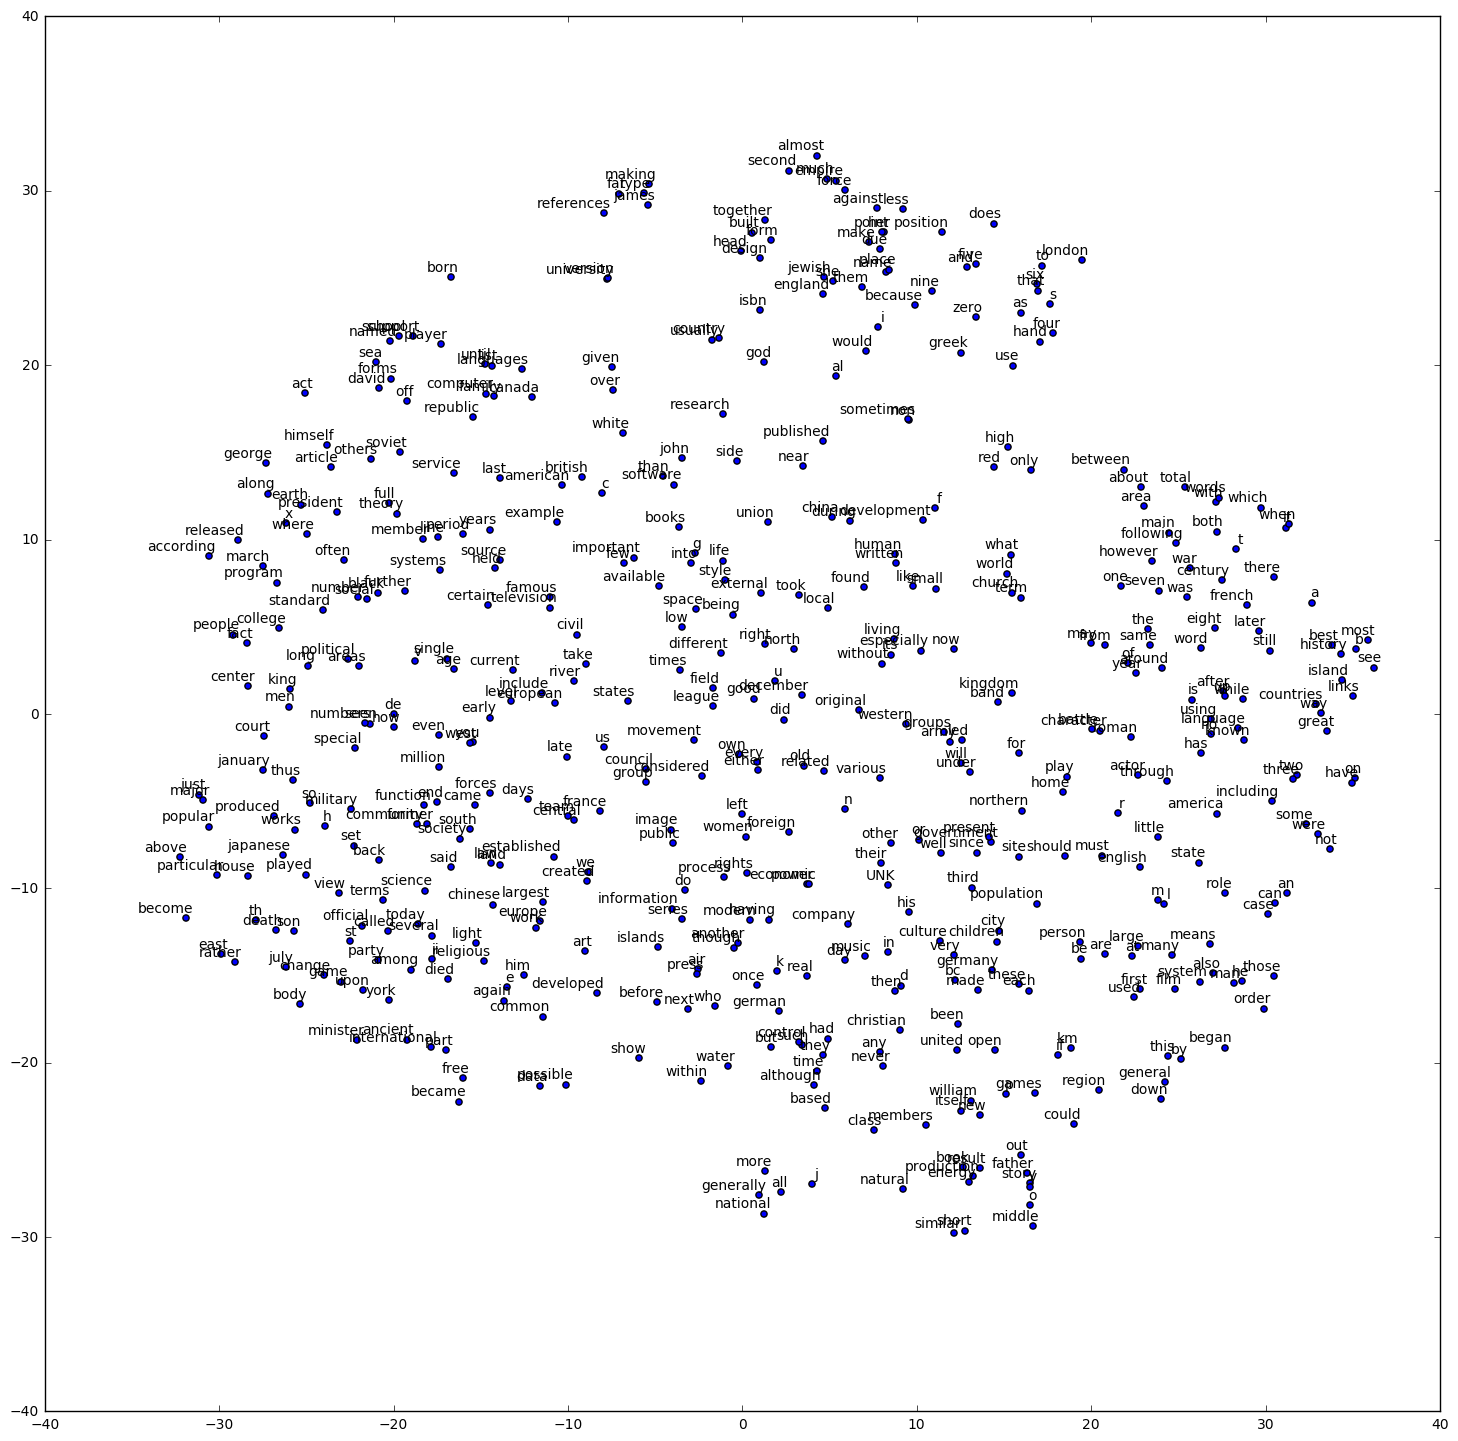

In [112]:
plot_only = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[1:plot_only+1, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

---

Task: CBOW
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### Step 7: Generate batch for the CBOW model.

In [18]:
data_index = 0
cbow_window = 2

def generate_cbow_batch(batch_size, cbow_window):
    global data_index 
    
    # your_code_here
    ...
    # your_code_here
    
    return batch, labels

In [ ]:
batch, labels = generate_cbow_batch(batch_size=3, cbow_window=cbow_window)

In [19]:
print('data:', [reverse_dictionary[di] for di in data[:5]])

for i in range(3):
    print("word:", reverse_dictionary[labels[i, 0]])
    print("context:", [reverse_dictionary[batch[i, j]] for j in range(2*cbow_window)])

data: ['anarchism', 'originated', 'as', 'a', 'term']
word: anarchism
context: ['UNK', 'UNK', 'originated', 'as']
word: originated
context: ['UNK', 'UNK', 'as', 'a']
word: as
context: ['UNK', 'originated', 'a', 'term']


### Step 8: Build CBOW model.

In [20]:
class CbowModel(object):
    def __init__(self, 
                 vocabulary_size=50000, batch_size=128, embedding_size=128, 
                 cbow_window=2, 
                 valid_size=16, valid_window=100, num_sampled=64):
        # do not change this
        self.vocabulary_size = vocabulary_size
        
        self.batch_size = batch_size
        self.embedding_size = embedding_size    # Dimension of the embedding vector.
        self.cbow_window = cbow_window 
        
        self.valid_size = valid_size            # Random set of words to evaluate similarity on.
        self.valid_window = valid_window        # Only pick dev samples in the head of the distribution.
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)
        self.num_sampled = num_sampled          # Number of negative examples to sample.
        
        self.build_model()
    
    
    def build_model(self):
        # your_code_here
        ...
        # your_code_here
    
    
    def train(self, num_steps, verbose=True):
        with tf.Session(graph=self.graph) as session:
            tf.initialize_all_variables().run()
            if verbose:
                print('Initialized')

            average_loss = 0
            for step in range(num_steps):
                # your_code_here
                ...
                # your_code_here
                
                if verbose and step % 2000 == 0:
                    if step > 0:
                        average_loss = average_loss / 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step %d: %f' % (step, average_loss))
                    average_loss = 0

                # note that this is expensive (~20% slowdown if computed every 500 steps)
                if verbose and step % 10000 == 0:
                    sim = self.similarity.eval()
                    for i in range(self.valid_size):
                        valid_word = reverse_dictionary[self.valid_examples[i]]
                        top_k = 8  # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                        log = 'Nearest to %s:' % valid_word
                        for k in range(top_k):
                            close_word = reverse_dictionary[nearest[k]]
                            log = '%s %s,' % (log, close_word)
                        print(log)

            final_embeddings = ...
            return final_embeddings

### Step 9: Train CBOW model.

In [21]:
num_steps = 100001
data_index = 0

final_embeddings = CbowModel(vocabulary_size=50000, batch_size=128, embedding_size=128, 
                             cbow_window=2, 
                             valid_size=16, valid_window=100, num_sampled=64).train(num_steps)

Initialized
Average loss at step 0: 288.502533
Nearest to two: provincial, tetrahedron, pluto, kurtosis, irrational, http, pork, trent,
Nearest to he: malaysia, absurd, surface, jigs, curtailed, adalbert, meridians, lazarus,
Nearest to people: switchable, endurance, kellerman, anschluss, unconditional, gills, turbo, extras,
Nearest to may: notwithstanding, roms, segmentation, starting, scorer, infernal, squeezing, alumnus,
Nearest to it: sk, alligators, passengers, synapse, pulsars, protester, bor, grappelli,
Nearest to or: rejoin, faunas, histidine, u, transfection, trans, signature, geraldine,
Nearest to years: garrison, postulates, offline, heavier, soi, trs, hectic, sucked,
Nearest to there: scientology, modality, pid, comprised, domini, neutrinos, analysing, verde,
Nearest to would: girth, speaking, sympathy, adversaries, leaned, narbonne, druidism, monologue,
Nearest to into: punished, solemnity, sabra, telecasts, presidium, gloucestershire, amplitude, publicize,
Nearest to this:

### Step 10: Visualize embeddings.

In [22]:
def plot_with_labels(low_dim_embs, labels, filename='tsne_cbow.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))    # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

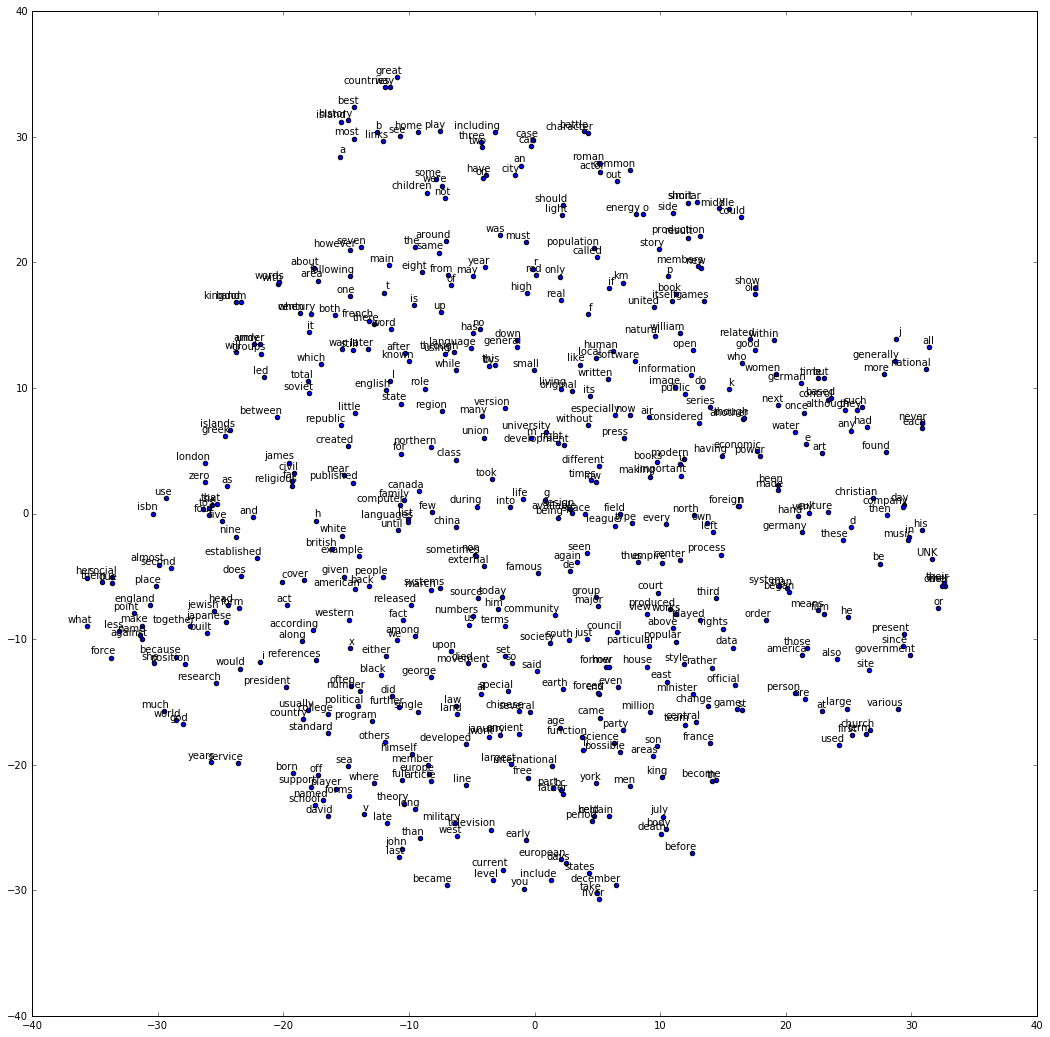

In [23]:
plot_only = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[1:plot_only+1, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)